In [8]:
#%pip install tensorflow
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, auc, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix, roc_curve, auc, precision_recall_curve,roc_curve, roc_auc_score
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization,ReLU,Add,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Model
import pickle
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
#from tensorflow_model_optimization.sparsity i

In [37]:
def eval_model(X_test,y_test,labels):
# Load the model from file
    model = load_model('pickles/model_keras.keras', compile=True)
    eval_metrics = model.evaluate(X_test, y_test)
    y_pred = model.predict(X_test)
    #revert the one hot encoding of the y_test
    y_pred_classes = np.argmax(y_pred, axis=1)
    print(y_pred_classes)
    auc_score= roc_auc_score(labels, y_pred, multi_class='ovr')
    acc = accuracy_score(labels, y_pred_classes)
    precision = precision_score(labels, y_pred_classes, average='weighted')
    recall = recall_score(labels, y_pred_classes, average='weighted')
    f1 = f1_score(labels, y_pred_classes, average='weighted')
    mcc = matthews_corrcoef(labels, y_pred_classes)
    loss = eval_metrics[0]
    cm = confusion_matrix(labels, y_pred_classes)
    history= pd.read_json('pickles/history.json', orient='index')
    
    return acc, auc_score, precision, recall, f1, mcc, loss, cm, y_pred,history

In [28]:

# Load the saved datasets
def load_from_pickle(path):
    with open(path, 'rb') as file:
        return pickle.load(file)


X = load_from_pickle('pickles/X.pkl')
y = load_from_pickle('pickles/y.pkl')
#

In [39]:
 #Convert labels to one-hot encoding
y_one_hot = to_categorical(y, num_classes=7)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y_one_hot, 
    test_size=0.3,
    random_state=1,
    stratify=y
)
# Find the index of the non-zero element in each row
labels = np.argmax(y_test, axis=1)  # Adding 1 to convert 0-based indexing to 1-based indexing
print(y_one_hot[6:10])
print(labels[6:10])

[[0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]
[0 2 0 2]


In [40]:
acc, auc_score, precision, recall, f1, mcc, loss, cm, y_pred,history =eval_model(X_test,y_test,labels)

c:\Users\saidm\.pyenv\pyenv-win\versions\3.11.0\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8612 - loss: 0.7374
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step
[2 1 2 ... 0 0 6]


In [41]:
df_results = pd.DataFrame({
    'Metric': ['Accuracy', 'AUC', 'Precision', 'Recall', 'F1', 'MCC', 'Loss'],
    'Score': [acc, auc_score, precision, recall, f1, mcc, loss]
})
print(df_results)
print('Confusion Matrix:')
print(cm)


      Metric     Score
0   Accuracy  0.866750
1        AUC  0.982039
2  Precision  0.870303
3     Recall  0.866750
4         F1  0.866094
5        MCC  0.832323
6       Loss  0.658890
Confusion Matrix:
[[1680  158  133   22    4   10    5]
 [  84 1712  176   13   10    7    1]
 [  43   59 1799   46   16    7    8]
 [   8    6   26  867    5    9    4]
 [   5   27   64   67  420    1    5]
 [   1    1    0    0    0  254    0]
 [  14    4    6    4    2    1  176]]


In [42]:

# Define function to plot AUC-ROC and Precision-Recall curves for multiclass
from itertools import cycle
from sklearn.calibration import label_binarize
def plot_curves(y_true, y_pred_prob, n_classes):
        # Binarize the output
        y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4, 5, 6])

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Compute Precision-Recall curve for each class
        precision = dict()
        recall = dict()
        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])

        plt.figure(figsize=(10, 5))

        # Plot ROC curve for each class
        plt.subplot(1, 2, 1)
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'yellow'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")

        # Plot Precision-Recall curve for each class
        plt.subplot(1, 2, 2)
        for i, color in zip(range(n_classes), colors):
            plt.plot(recall[i], precision[i], color=color, lw=2, label='Precision-Recall curve of class {0}'.format(i))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")

        plt.tight_layout()
        plt.show()

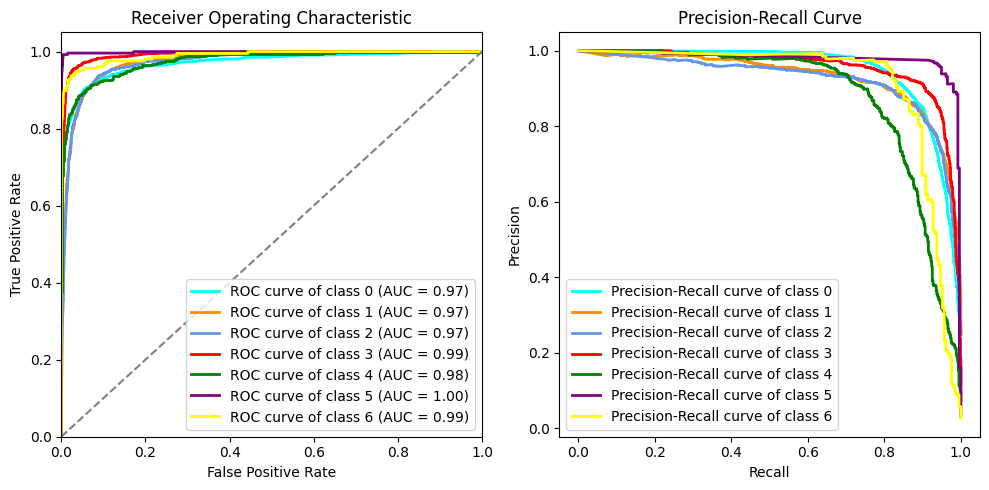

In [43]:
plot_curves(y_test, y_pred, n_classes=7)

In [44]:
def plot_curves_v2(y_true, y_pred_prob, n_classes):
    # Binarize the output
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3, 4, 5, 6])

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute Precision-Recall curve for each class
    precision = dict()
    recall = dict()
    
    # Compute micro-average Precision-Recall curve and area
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true_bin.ravel(), y_pred_prob.ravel())

    plt.figure(figsize=(10, 5))

   #calculate the mean of the roc_auc_score
    all_auc = np.mean(list(roc_auc.values()))
    # Plot all_auc score
    plt.subplot(1, 2, 1)
    plt.plot(fpr["micro"], tpr["micro"], color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % all_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic mean AUC')
    plt.legend(loc="lower right")
    
    # Plot all_precision-recall score
    plt.subplot(1, 2, 2)
    plt.plot(recall["micro"], precision["micro"], color='green', lw=2, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve mean Precision and Recall')
    plt.legend(loc="lower left")
    

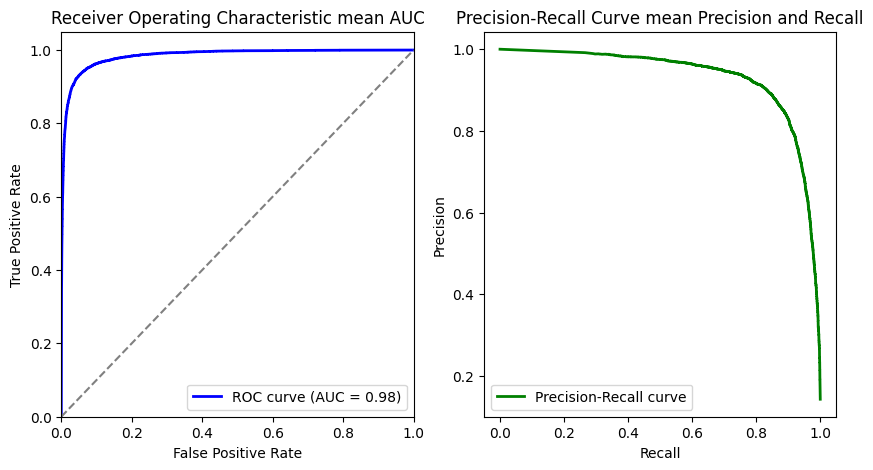

In [45]:
plot_curves_v2(y_test, y_pred, n_classes=7)

In [49]:
history.T

,accuracy,loss,val_accuracy,val_loss
0,0.412476,2.623299,0.263739,6.947646
1,0.500887,1.464433,0.359473,2.195029
2,0.538855,1.220435,0.343287,2.828465
3,0.555633,1.108845,0.315935,5.360461
4,0.585104,1.004835,0.371644,3.160794
...,...,...,...,...
195,0.960258,0.101268,0.760728,2.998587
196,0.965475,0.081546,0.870640,0.650156
197,0.967733,0.072727,0.848055,0.838259
198,0.962786,0.099986,0.748557,2.639342


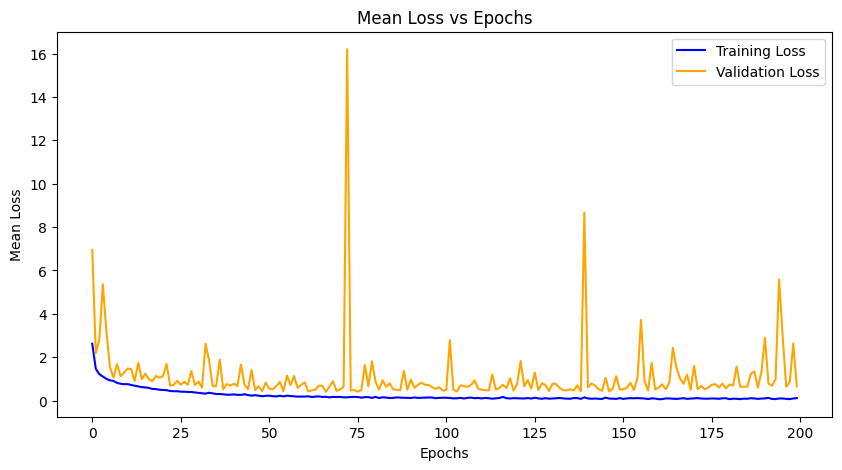

In [51]:
#the loss is on  the index 
plt.figure(figsize=(10, 5))
plt.plot(history.T['loss'], label='Training Loss', color='blue')
plt.plot(history.T['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Mean Loss')
plt.title('Mean Loss vs Epochs')
plt.legend()